<a href="https://colab.research.google.com/github/Kicory/ML_StockPJ/blob/master/Notebook/TheGrandPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.
제가 train을 하고 파라미터 파일은 아마도 깃에 올리지 않을까... 생각합니다. 깃이랑 colab이랑 마운트해서 사용할 수 있는 방법이 있을까 계속 찾아봤는데 없는 것 같네요. 귀찮지만...

In [0]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# for teaching force
import random

# for CSV
import pandas as pd
import numpy as np

#from torch.utils.data import DataLoader

In [0]:
torch.manual_seed(470)
torch.cuda.manual_seed(470)

In [0]:
maxEpoch = 1
learningRate = 0.005
batchSize = 4
device = 'cuda'

In [0]:
data_dir = os.path.join(gdrive_root, 'Project/Data')

# 시작하기
이 프로젝트에서는 좀 특이한 방식으로 데이터 처리를 해야 합니다. 이유는 다음과 같습니다.

pytorch.nn 의 모듈을 상속받아 만든 클래스로 어떤 모델을 만들었다고 해 봅시다. 해당 모델의 desirable input dimension이 n이라고 합시다.


*   minibatch갯수가 1일 때: n차원의 input을 넣으면 정상 작동(당연)
*   minibatch갯수가 2이상: n + 1차원의 input을 넣음(???)

pytorch가 용하게도 input의 첫 번째 원소를 minibatch의 갯수로 인식하고 input을 minibatch 수만큼 갈라서 병렬 처리를 하는 겁니다. 그러면 input은 n차원의 minibatch개 input으로 나뉘어집니다. 이게 기본 작동 원리입니다.

일반적인 방법으로 데이터를 쪼개면 이런 관례에 따라 minibatch 갯수가 첫 차원의 원소로 들어가게 됩니다. 그런데 지금 우리가 가지고 있는 데이터셋을 일반적인 방법으로 쪼갠다면 다음과 같은 모양을 하게 됩니다.

*   (minibatch 수, 연속된 주식 정보 갯수, 주식 정보(5))

이걸 LSTMCell에 넣으려면 (minibatch, 주식 정보(5))로 가공해서 연속적으로 넣어야 합니다. 그 말인즉슨 0번째 차원과 1번째 원소를 뒤바꿔야 하는데 이거 엄청 비효율입니다.

따라서 데이터셋 가공에 신경을 써서 

*   (연속된 주식 정보 갯수, minibatch 수, 주식 정보(5))

으로 만들어야 합니다.

In [0]:
#pd.read_csv(os.path.join(data_dir, '000020.KS.csv'), sep=',', nrows=10, usecols=[1, 2, 3, 4, 5]).to_numpy()

In [0]:
# 이게 되려나???
def getInputData(theFile, length, batchSize):
  reader = pd.read_csv(theFile, sep=',', chunksize=length * batchSize, usecols=[1, 2, 3, 4, 5])
  for chunk in reader:
    if chunk.shape[0] != length * batchSize:
      return
    yield torch.Tensor(chunk.to_numpy().reshape(batchSize, length, 5).swapaxes(0, 1))

# 2. 모델 설명

예를 들어 10일간의 주식 정보를 minibatch 4 개로 해서 train 한다.
hidden size가 32다.
*   x.size() = [10, 4, 5]
*   h0.size(), c0.size() = [4, 32] (근데 이건 어차피 0으로 초기화되니 굳이 설정할 필요는 없..)
*   futureRatio = 얼마만큼을 '예측할' 그래프로 할 것인지
 *   0.5라면 절반 만큼은 teacherForcing 100%, 절반은 teacherForcing 적게.
*   TFRatio = 예측하는 그래프에서 teacherForcing이 일어날 확률.



In [0]:
class GrandPredictor(nn.Module):
  def __init__(self, hiddenSize=32):
    super(GrandPredictor, self).__init__()

    self.lstm = nn.LSTMCell(5, hiddenSize)
    self.FCout = nn.Linear(hiddenSize, 5)

  def forward(self, x):
    h, c = self.lstm(x)
    prediction = self.FCout(h)
    return (prediction, h, c)



In [0]:
predictor = GrandPredictor(256)
predictor = predictor.to(device)

# Print your neural network structure
print(predictor)

optimizer = optim.SGD(predictor.parameters(), lr=learningRate)

GrandPredictor(
  (lstm): LSTMCell(5, 256)
  (FCout): Linear(in_features=256, out_features=5, bias=True)
)


In [0]:
ckpt_dir = os.path.join(gdrive_root, 'Project/checkpoints')

if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)
  
best_acc = 0.

ckpt_path = os.path.join(ckpt_dir, 'lastest.pt')
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    predictor.load_state_dict(ckpt['predictor'])
    optimizer.load_state_dict(ckpt['optimizer'])
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')

In [0]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [0]:
def predictorTrainer(predictor, x, futureRatio=0.5, TFRatio=0.5):
    seqLen = x.size()[0]
    output = []
    prevPrediction = None
    predictFrom = int(seqLen * futureRatio)
    
    assert predictFrom >= 1, 'No given data, no prediction.'

    for day in range(0, predictFrom):
      h, c = self.lstm(x[day])
      prevPrediction = self.FCout(h)
      output.append(prevPrediction.clone())
    
    for day in range(predictFrom, seqLen):
      if random.uniform(0, 1) > TFRatio:
        # No Teach forcing.
        h, c = self.lstm(prevPrediction, (h, c))
      else:
        # Yes, Teach forcing.
        h, c = self.lstm(x[day], (h, c))
      
      prevPrediction = self.FCout(h)
      output.append(prevPrediction.clone())

    return torch.stack(output)

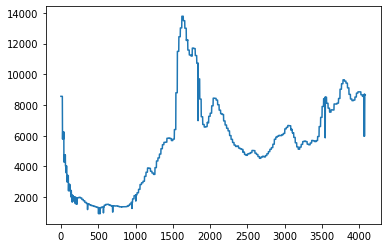

In [0]:
# Training process

it = 0
predictor.train()

losses = []
prices = []

for epoch in range(1):
  reader = getInputData(os.path.join(data_dir, '000020.KS.csv'), 20, 1)
  predictor.train()
  for data in reader:
    it = it + 1
    data = data.to(device);

    esti = predictor(data, 1, 0.5)
    
    loss = F.mse_loss(esti[:, :, 3], data[:, :, 3])
    prices += esti[:, :, 3].cpu().detach().view(20).tolist()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


plt.plot(prices, label='train loss')

In [0]:
def testDataLoader(theFile):
  reader = pd.read_csv(theFile, sep=',', chunksize=1, usecols=[1, 2, 3, 4, 5])
  for chunk in reader:
    yield torch.Tensor(chunk.to_numpy())

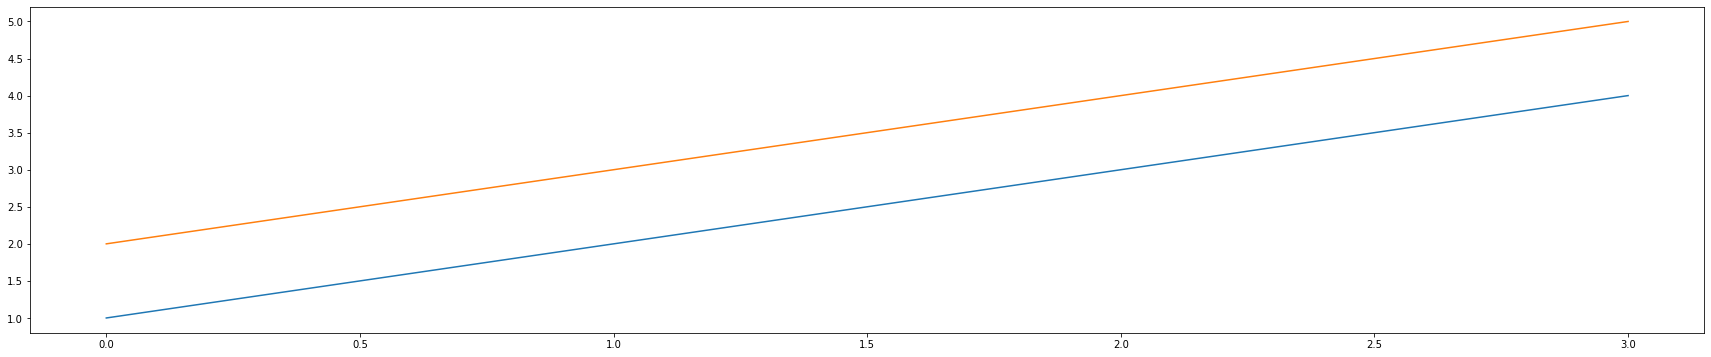

In [20]:
from google.colab import widgets

def drawStepFig(trueCnt, estiCnt):
  predictor.eval()
  plt.figure(figsize=(30, 6))
  trueData = []
  trueVals = []
  estiVals = []
  reader = testDataLoader(os.path.join(data_dir, '000020.KS.csv'))

  for data in reader:
    if len(trueVals) > trueCnt + estiCnt:
      trueVals.pop(0)
    trueVals.append(data[3].item())
    trueData.append(data)
    if len(trueData) < estiCnt + 1:
      continue
    else:
      predictor
    
  

In [0]:
import plotly